In [9]:
#!/usr/bin/env python
import argparse
import alignment
import alignment.helper
import numpy as np
from pathinference import PathInference
from pathinference.kernel import EQ
import btinference
import os
import sys
from pathlib import Path


datapath = '/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2'
calset = 'cal'
sourcename = 'btinference'
tagsource = 'btviewer'
keepcolour = False
lengthscale = 2
kernelscale = 50

datapath = Path(datapath)
sessionpath = datapath.parent
calsetpath = sessionpath.joinpath(calset)
alignmentsourcename = 'btalignment'

#Get the calibration set paths (to each relevant camera)
calsetpaths = list(calsetpath.glob('*/*'))
if not keepcolour:
    allcalimgfiles = [sorted(p.glob('*.np')) for p in calsetpaths]
    print("Removing colour cameras from set")
    #TODO Convert helper function to use pathlib
    greyscale = [alignment.helper.guesscamtypegetscore(imgfiles[0])<0.02 for imgfiles in allcalimgfiles]    
    calsetpaths = [p for p,g in zip(calsetpaths,greyscale) if g]


#load the tag datafiles (for relevant cameras)
tagsetpaths = list(datapath.glob('*/*'))
if not keepcolour:
    alltagimgfiles = [sorted(p.glob('*.np')) for p in tagsetpaths]
    print("Removing colour cameras from set")
    greyscale = [alignment.helper.guesscamtypegetscore(imgfiles[0])<0.02 for imgfiles in alltagimgfiles]
    tagsetpaths = [p for p,g in zip(tagsetpaths,greyscale) if g]

#Print information
print("Base path: %s" % datapath.as_posix())
print("Searched %s for calibration sets." % calsetpath.as_posix())
print("Using these calibration sets:")
for p in calsetpaths:
    print("  "+p.as_posix())
    
print("Using these tag sources:")
for p in tagsetpaths:
    print("  "+p.as_posix())
    
    
#Start analysis (camera positions, observations, paths)
cameras = btinference.getcameras(calsetpaths, alignmentsourcename)
obstimes, observations, obsfrom = btinference.getobservations(tagsetpaths,tagsource,cameras)

print("Found %d observations." % len(observations))
if len(observations)==0:
    print("No observations found.")
    sys.exit()
    
print("Inferring flight path...")
kernel = EQ(lengthscale, kernelscale)
pathi = PathInference(obstimes, observations, kernel, likenoisescale=0.02)
pathi.run(500,0.05)
Xtest = pathi.buildinputmatrix(500)
M,C = pathi.getpredictions(Xtest)
btinference.makeanimation(Xtest,observations,obstimes,M,C)

Removing colour cameras from set
Removing colour cameras from set
Base path: /home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2
Searched /home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/cal for calibration sets.
Using these calibration sets:
  /home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/cal/12/02G14695547
  /home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/cal/14/02G06394393
  /home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/cal/10/02D49670796
  /home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/cal/13/02G14695548
Using these tag sources:
  /home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/12/02G14695547
  /home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/14/02G06394393
  /home/mike/Documents/Research/

2024-07-03 16:04:35.134960: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-07-03 16:04:35.278865: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


0 [nan]
Had likely non-positive definite covariance, increasing jitter to 0.00001
0 [nan]
Had likely non-positive definite covariance, increasing jitter to 0.00010


2024-07-03 16:04:35.418855: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


0 [nan]
Had likely non-positive definite covariance, increasing jitter to 0.00100
0 [531579.8]
20 [135134.31]
40 [45424.2]
60 [16318.406]
80 [7430.0347]
100 [3888.551]
120 [2411.9216]
140 [1704.8013]
160 [1343.5487]
180 [1172.2185]
200 [1114.9089]
220 [1028.2998]
240 [962.0449]
260 [1012.5936]
280 [1079.1317]
300 [1188.8967]
320 [1033.3253]
340 [1181.0212]
360 [1173.5869]
380 [1349.1575]
400 [1565.26]
420 [1635.0964]
440 [2090.7595]
460 [2184.724]
480 [3119.115]


In [10]:
#c = cameras['12/02G14695547']
#vec = get_pixel_local_vector(c,np.array([123.0,456]))*100+c.loc
#print(vec)
#get_pixel_loc(c,vec)

In [11]:
from alignment import Camera
import json
from pathlib import Path
import numpy as np
import re
from pathinference.helper import confidence_ellipse
import matplotlib.pyplot as plt
import matplotlib.animation as animation
def makeanimationsideview(Xtest,observations,obstimes,M,C,animationfilename='animationside.mp4'):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(5,5)
    plt.axis('equal')
    times = Xtest.numpy()[:int(len(Xtest.numpy())/3),0]
    mintime = np.min(times)
    maxtime = np.max(times)
    def animate(i):
        ax.clear()
        
        for obs,t in zip(observations,obstimes):
            anitime = (i/10+mintime)
            #plt.title("%0.1f" % (i/10))
            alpha = 1-3*np.abs(t-anitime)
            
            if alpha>0:
                ax.plot([obs[0],obs[0]+obs[3]*10],[obs[2],obs[2]+obs[5]*10],color='grey',alpha=alpha)
                ax.add_patch(plt.Circle([obs[0],obs[2]],0.1,color='red'))
        
        #ax.plot(M.numpy()[stds<0.25,0],M.numpy()[stds<0.25,1])            
        ax.set_xlim([-1,10])
        ax.set_ylim([-5,5])
        
        idx = np.argmin(np.abs(times-(i/10+mintime)))
        pix = M[idx,:]
        c = C[idx,:,:].numpy()
        
        ax.add_patch(confidence_ellipse(M[idx,:].numpy()[[0,2]],np.array([[c[0,0],c[0,2]],[c[2,0],c[2,2]]]),ax))

    ani = animation.FuncAnimation(fig, animate, frames=int(10*(maxtime-mintime)),
                        interval=100, repeat=False)
    plt.close()
    # Save the animation as an animated GIF
    #ani.save("simple_animation.gif", dpi=900, writer=PillowWriter(fps=0.1))
    FFwriter = animation.FFMpegWriter(fps=10)
    ani.save(animationfilename, writer = FFwriter) 
    
makeanimationsideview(Xtest,observations,obstimes,M,C)

(0.0, 2.0)

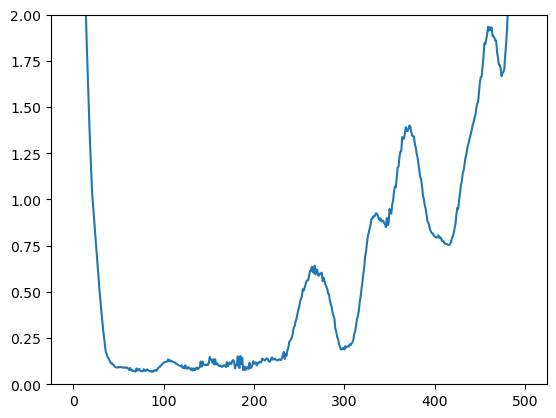

In [12]:
plt.plot([np.sqrt(np.max(np.diag(c))) for c in C.numpy()])
plt.ylim([0,2])

In [13]:
import re
def totalsecsandms(st):
    time_hms = [int(s) for s in re.findall('([0-9]{1,2})[:\+]([0-9]{2})[:\+]([0-9]{2}).([0-9]{6})',st)[0]]
    return time_hms[0]*3600 + time_hms[1]*60 + time_hms[2]*1 + time_hms[3]/1e6

filenames = list(datapath.rglob('*.np'))
times = np.array([totalsecsandms(fn.as_posix()) for fn in filenames])

In [15]:
import pathlib
import json
M, C = pathi.getpredictions(pathi.buildinputmatrix(times))
for fn, t, m, c in zip(filenames,times,M,C):
    if np.max(np.diag(c))>0.1: continue
    pathparts = fn.parts
    jsonf = pathparts[-1][:-2]+'json'
    camid = pathparts[-2]
    boxid = pathparts[-3]
    camstid = boxid+'/'+camid
    print(camstid)
    if camstid in cameras:
        cam = cameras[camstid]
        pixelpos = cam.get_pixel_loc(m.numpy())[0]
        jsonfn = Path(*list(pathparts)[:-1]+['btinference']+[jsonf])

        json_item = {"x":int(pixelpos[0]),"y":int(cam.res[1]-pixelpos[1]), "source": "btinference", "version": "btinference, v1.0", "meta":"", "label":"%0.3f" % np.max(np.sqrt(np.diag(c)))}
        pathlib.Path(jsonfn).parents[0].mkdir(parents=True, exist_ok=True)
        print(jsonfn)        
        json.dump([json_item],open(jsonfn,'w'))

12/02G14695547
/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/12/02G14695547/btinference/20240620_14+29+45.552898_0340.json
12/02G14695547
/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/12/02G14695547/btinference/20240620_14+29+47.110933_0347.json
12/02G14695547
/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/12/02G14695547/btinference/20240620_14+29+48.064486_0350.json
12/02G14695547
/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/12/02G14695547/btinference/20240620_14+29+46.558197_0344.json
12/02G14695547
/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/12/02G14695547/btinference/20240620_14+29+44.092704_0335.json
12/02G14695547
/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/12/02G14695547/btinference/20240620_14+29+45.050647_03

10/02D49670796
/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/10/02D49670796/btinference/20240620_14+29+38.558455_0298.json
10/02D49670796
/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/10/02D49670796/btinference/20240620_14+29+39.671203_0303.json
10/02D49670796
/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/10/02D49670796/btinference/20240620_14+29+47.664345_0333.json
10/02D49670796
/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/10/02D49670796/btinference/20240620_14+29+40.148616_0304.json
10/02D49670796
/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/10/02D49670796/btinference/20240620_14+29+42.872162_0315.json
10/02D49670796
/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/10/02D49670796/btinference/20240620_14+29+40.664277_03

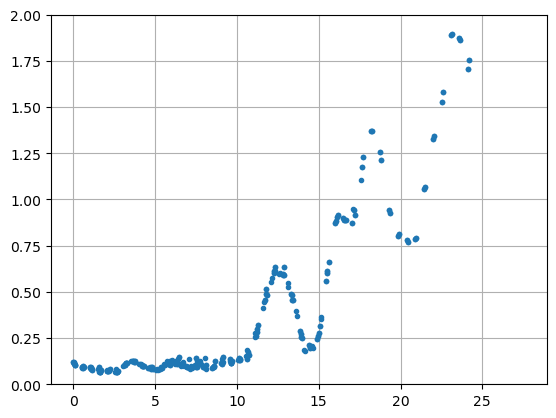

In [21]:
plt.plot(times-min(times),[np.sqrt(np.max(np.diag(c))) for c in C.numpy()],'.')
plt.ylim([0,2])
plt.grid()

[0.0021162257,
 0.0024675038,
 0.00261969,
 0.05269306,
 0.0022338452,
 0.059079934,
 0.002711325,
 0.0021244087,
 0.0022141673,
 0.007563358,
 0.0030469107,
 0.19699392,
 0.0026788148,
 0.0036934495,
 0.0034905532,
 0.0024783546,
 0.0023061428,
 0.0028320649,
 0.002338796,
 0.0023285751,
 0.002202164,
 0.0021295608,
 0.002192387,
 0.0022444646,
 0.1503294,
 0.2385745,
 0.003457178,
 0.0027599344,
 0.0020929577,
 0.0023122465,
 0.002580705,
 0.002366027,
 0.0020676572,
 0.0024262387,
 0.0077304714,
 0.1228225,
 0.0023359116,
 0.010296799,
 0.0020869656,
 0.0022465629,
 0.058960143,
 0.0029705847,
 0.0023265886,
 0.007799492,
 0.0020334038,
 0.0035679305,
 0.0031050122,
 0.0014321858,
 0.0020868857,
 0.035999004,
 0.2157002,
 0.0022403852,
 0.15896873,
 0.0028466077,
 0.19972362,
 0.0023209215,
 0.0025516395,
 0.11484993,
 0.0023040855,
 0.029584888,
 0.05055917,
 0.0030432926,
 0.5986783,
 0.01583809,
 0.0024905514,
 0.0024388046,
 0.002001681,
 0.0025005483,
 0.0019441019,
 0.6250743,

In [14]:
!ls /home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/12/02G14695547/btinference

20240620_14+29+38.010896_0310.json  20240620_14+29+45.603756_0341.json
20240620_14+29+38.061737_0311.json  20240620_14+29+46.055887_0342.json
20240620_14+29+38.513385_0312.json  20240620_14+29+46.106691_0343.json
20240620_14+29+38.564227_0313.json  20240620_14+29+46.558197_0344.json
20240620_14+29+39.015821_0314.json  20240620_14+29+46.608856_0345.json
20240620_14+29+39.066686_0315.json  20240620_14+29+47.060307_0346.json
20240620_14+29+39.518285_0316.json  20240620_14+29+47.110933_0347.json
20240620_14+29+39.569147_0317.json  20240620_14+29+47.562386_0348.json
20240620_14+29+40.020743_0318.json  20240620_14+29+47.613046_0349.json
20240620_14+29+40.071586_0319.json  20240620_14+29+48.064486_0350.json
20240620_14+29+40.523019_0320.json  20240620_14+29+48.115126_0351.json
20240620_14+29+40.573622_0321.json  20240620_14+29+48.566623_0352.json
20240620_14+29+41.024848_0322.json  20240620_14+29+48.617263_0353.json
20240620_14+29+41.075440_0323.json  20240620_14+29+49.068683_0354.json
202406

In [50]:
M[0,:].numpy())

array([[-1777.06957392,   667.6778462 ]])

In [3]:
for obst, obs, fn in zip(observations, obstimes, obsfrom):
    M, C = pathi.getpredictions(pathi.buildinputmatrix(obstimes))
    pathparts = obsfn.parts
    jsonfn = pathparts[-1]
    camid = pathparts[-3]
    boxid = pathparts[-4]
    camstid = boxid+'/'+camid
    cam = cameras[camstid]
    

[PosixPath('/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/12/02G14695547/btviewer/20240620_14+29+51.083506_0362.json'),
 PosixPath('/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/12/02G14695547/btviewer/20240620_14+29+52.594301_0368.json'),
 PosixPath('/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/12/02G14695547/btviewer/20240620_14+29+45.552898_0340.json'),
 PosixPath('/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/12/02G14695547/btviewer/20240620_14+29+39.015821_0314.json'),
 PosixPath('/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/12/02G14695547/btviewer/20240620_14+29+42.028430_0326.json'),
 PosixPath('/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/12/02G14695547/btviewer/20240620_14+29+44.544176_0336.json'),
 PosixPath

array([[-1777.06957392,   667.6778462 ]])

array([0.5930251 , 0.6861789 , 0.02457595], dtype=float32)

In [19]:
cam.get_pixel_loc(np.array([100,200,300]))

array([[-3817.60756501, -6494.41134752]])

In [3]:
for camsetid, cam in cameras.items():
    print(camsetid)

12/02G14695547
14/02G06394393
10/02D49670796
13/02G14695548


In [7]:
isinstance(2,int)

True

In [ ]:
pathi.buildinputmatrix

In [ ]:
pathi.getpredictions()

In [ ]:
cam.get_pixel_loc()

In [27]:
cam.get_pixel_local_vector(np.array([100,200])),cam.get_pixel_vector(np.array([100,200]))

UnboundLocalError: local variable 'pvec' referenced before assignment

In [25]:
cam.get_pixel_vector()

In [22]:
def drawpredictions(cameras):
    """
    Given a list of paths to the sets we want to use, the name of the tool that made the tags and the
    dictionary of cameras, return the list of observation times, and observations.
    
    The observation times are an array of N times, the observations are a Nx6 array.
    
    tagsetpaths: list of paths to sets (e.g. ['Session1/set2/12/02G14695547',Session1/set2/14/02G06394393'])
    tagsource: name of the source of the markers (e.g. btviewer) 
    cameras: dictionary of cameras (indexed by 'box/cam')
    """
    obstimes = []
    observations = []

    for path in tagsetpaths:
        camsetid = getcamsetid(path)
        tagsourcefiles = path.glob(tagsource+'/*.json')

        c = cameras[camsetid]
        for fn in tagsourcefiles:
            jsondata = json.load(open(fn,'r'))
            pixelcoord = np.array([jsondata[0]['x'],jsondata[0]['y']]).astype(float)
            vect = c.get_pixel_local_vector(pixelcoord)
            obstimes.append(totalsecsandms(fn.as_posix()))
            observations.append(np.r_[c.loc,vect])                
    observations = np.array(observations)
    obstimes = np.array(obstimes)
    return obstimes, observations

In [ ]:
from scipy.spatial.transform import Rotation as R
def get_local_loc(self, spatial_position):
    """
    Given a global location, compute location in camera coordinates in 3d.
    """
    p = np.array(spatial_position - self.loc)

    r1 = R.from_euler('z', self.orientation[0], degrees=False) #yaw
    r2 = R.from_euler('Y', self.orientation[1], degrees=False) #pitch (intrinsic rotation around y axis)    
    r3 = R.from_euler('X', self.orientation[2], degrees=False) #roll (intrinsic rotation around x axis)    
    pvec = r3.apply(r2.apply(r1.apply(p)))
    return pvec

def get_pixel_loc(self, coordinates,addstarttoend=False):
        """
        What 2d pixel location will 3d coordinates have for this camera.
        """
        pvec = self.get_local_loc(coordinates)
        
        
        if len(pvec.shape)==1:
            pvec = pvec[None,:]
        #We look down the x-axis...with x-axis being distance
        pvec[pvec[:,0]<0.001,0]=0.001 #nearly behind
        pixel_position = np.array([self.res[0]/2+self.res[0]*(-pvec[:,1]/pvec[:,0])/self.hfov,
                                   self.res[1]/2-self.res[1]*(-pvec[:,2]/pvec[:,0])/self.vfov]).T
        

        #assert np.all(np.array(self.old_get_pixel_loc(cam,markercoords))==res)
        if addstarttoend:
            return np.c_[pixel_position,pixel_position[:,0]]
        return pixel_position

def get_pixel_local_vector(self,pixel_position):
    """
    Given a pixel coordinate, what equivalent local vector does this correspond to?

    TODO Add a test:
            vec = c.get_pixel_local_vector(np.array([123.0,456]))*100+c.loc
            c.get_pixel_loc(vec)
    will return 123,456
    """
    #local_vector = [1,?,?]
    local_vector = np.array([0.0,0,0])
    local_vector[0] = 1.0
    local_vector[1] = -(self.hfov/self.res[0])*(pixel_position[0] - self.res[0]/2)
    local_vector[2] = -(self.vfov/self.res[1])*((self.res[1]-pixel_position[1]) - self.res[1]/2)




    r1 = R.from_euler('z', -self.orientation[0], degrees=False) #yaw
    r2 = R.from_euler('Y', -self.orientation[1], degrees=False) #pitch (intrinsic rotation around y axis)    
    r3 = R.from_euler('X', -self.orientation[2], degrees=False) #roll (intrinsic rotation around x axis)    
    pvec = r1.apply(r2.apply(r3.apply(local_vector)))

    #p = np.array(pvec + self.loc)        
    pvec/=np.sqrt(np.sum(pvec**2))
    return pvec